In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

## Oregonator Model

In [3]:
# System of ODE
def oregonator(t, y, e=1e-2, mu=1e-5, f=1.0, q=2e-4):

    """
    t : Current time t ( float )
    y :  [y1, y2, y3] at time t

    e : Parameter   e = 1e-2
    mu: Parameter   mu = 1e-5
    f : Parameter   f = 1
    q : Parameter   q = 2e-4

    Returns:
    dy :  [dy1/dt, dy2/dt, dy3/dt] at time t

    """

    # Handling overflow or Run-timer warning
    if np.any(np.abs(y) > 1e25):
        raise OverflowError("Overflow detected in Calculation. Need  more small time step h .")

    try:
      dy = np.zeros(3)
      dy[0] = y[1] - y[0]
      dy[1] = (q * y[2] - y[1] * y[2] + y[1] * (1 - y[1])) / e
      dy[2] = (-q * y[2] - y[1] * y[2] + f * y[0]) / mu

    except (OverflowError, ZeroDivisionError, ValueError) as e:
        raise RuntimeError(f"Error in ODE system at t={t}. {e}")

    return dy



## Methods

In [4]:
def forward_euler(f, y, h, t):

    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    '''

    return y + h * f(t, y)



# Runge-Kutta 2nd Order (RK2)
def RK2(f, y, h, t):

    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    '''

    k1 = f(t, y)
    k2 = f(t + h, y + h * k1)
    return y + (h / 2) * (k1 + k2)



# Runge-Kutta 4th Order (RK4)
def RK4(f, y, h, t):

    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    '''

    k1 = f(t, y)
    k2 = f(t + h / 2, y + h * k1 / 2)
    k3 = f(t + h / 2, y + h * k2 / 2)
    k4 = f(t + h, y + h * k3)

    return y + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

## Explicit Sovler

In [5]:
# Solving with Explicit method

def solve_IVP(f, y_init, h, t_end, method):

    """
    f       : Function defining the ODE system (f(t, y))
    y_init  : Initial condition
    h       : Step size
    t_end   : Final time for the solution
    method  : Method for solving System

    Returns:
    --------
    t_values :  time values ( t )
    y_values :  solution values [ y(t)  at t ]

    """

    # Storage for evaluations
    t_values = [0]
    y_values = [y_init]

    # Initialization
    current_time = 0
    y_current = np.array(y_init)

    while current_time < t_end:

        y_next = method(f, y_current, h, current_time) # return y1,y2,y3
        y_values.append(y_next)

        # Update time and current values
        current_time += h
        t_values.append(current_time)
        y_current = y_next

    return np.array(t_values), np.array(y_values)

# Task 1.  System Dynamics.

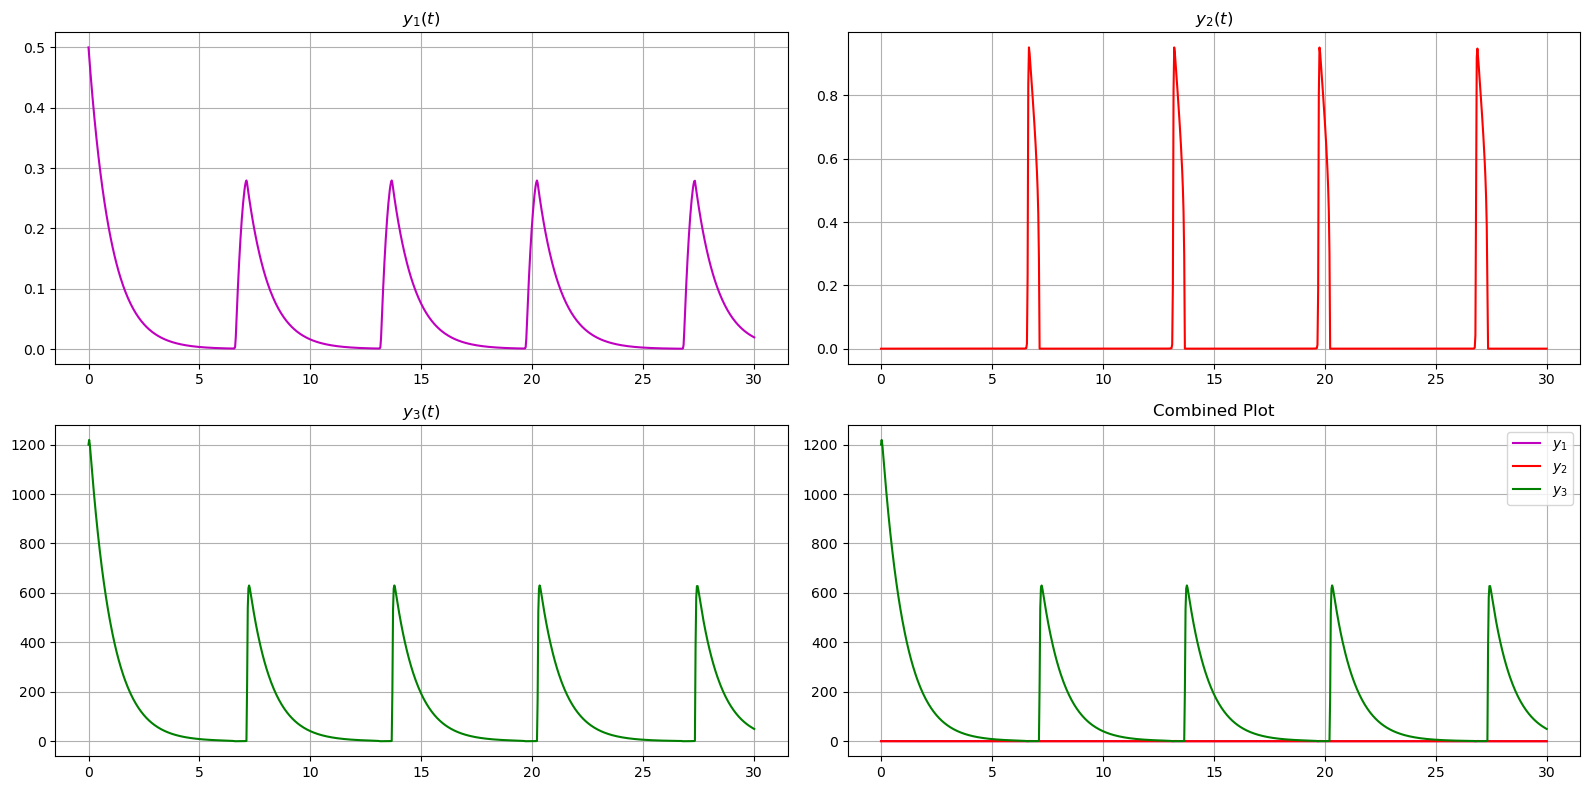

In [6]:
# Solving  the system using the 'Radau' method

# Initial conditions
y1_0 = 0.5
y2_0 = 0.0
y3_0 = 1200.0
initial_conditions = [y1_0, y2_0, y3_0]

# Time
t_scale = (0, 30)
t_eval = np.linspace(t_scale[0], t_scale[1], 1000)

solution = solve_ivp(oregonator, t_scale, initial_conditions, t_eval=t_eval, method='Radau')
t =  solution.t
y1, y2, y3 = solution.y

fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Individual plots
axs[0, 0].plot(t, y1, 'm'); axs[0, 0].set_title('$y_1(t)$'); axs[0, 0].grid()
axs[0, 1].plot(t, y2, 'r'); axs[0, 1].set_title('$y_2(t)$'); axs[0, 1].grid()
axs[1, 0].plot(t, y3, 'g'); axs[1, 0].set_title('$y_3(t)$'); axs[1, 0].grid()

# Combined plot
axs[1, 1].plot(t, y1, 'm', label='$y_1$')
axs[1, 1].plot(t, y2, 'r', label='$y_2$')
axs[1, 1].plot(t, y3, 'g', label='$y_3$')
axs[1, 1].set_title('Combined Plot'); axs[1, 1].legend(); axs[1, 1].grid()

# Output
plt.tight_layout()
plt.show()


## Qualitative Analysis of System Stiffness ( May be we can change it later )

The stiffness of a system refers to the presence of fast and slow dynamics over short timescales. This system exhibits stiffness mainly due to the presence of small parameters $ \epsilon $ and $ \mu $.

1. The parameter $ \epsilon = 1 \times 10^{-2} $ and $ \mu = 1 \times 10^{-5} $ are significantly small. These small parameters suggest that certain terms in the system's differential equations (specifically for $ y_2 $ and $ y_3 $) will evolve on much shorter timescales compared to others.

    - $ y_2(t) $: The dynamics of $ y_2 $ involve a division by $ \epsilon $, which amplifies changes in $ y_2 $ over short periods.
    - $ y_3(t) $: The presence of the $ \mu $ parameter in the denominator of the equation for $ y_3 $ suggests extremely rapid changes in this variable initially, before stabilizing over a longer period.
&nbsp;
2. Additionally, these equations are nonlinear and interdependent, with interactions between $ y_1 $, $ y_2 $, and $ y_3 $. This high interdependence leads to stiffness when small variations in one variable cause rapid changes in others.
&nbsp;
3. The initial conditions $ y_1(0) = 0.5 $, $ y_2(0) = 0 $, and $ y_3(0) = 1200 $ also contribute to the system's stiffness.These differences in initial values highlight the different time scales in the system, making it even stiffer.

    - The large initial value of $ y_3(0) = 1200 $ relative to $ y_1(0) $ and $ y_2(0) $ increases the fast dynamics governed by $ \mu $, leading to rapid changes in $ y_3(t)$.
    - Since $ y_2(0) = 0 $, the term $\frac{y_2}{\epsilon} $ starts from a very small value but grows rapidly, amplifying the fast changes in $ y_2 $.



# Task 2

In [7]:
# Initialization

# Initial conditions
y1_0 = 0.5
y2_0 = 0.0
y3_0 = 1200.0
initial_conditions = [y1_0, y2_0, y3_0]
n = 2000000  # Number of separations

# Time
t_scale = (0, 30)
t_end = t_scale[-1]
h = (t_scale[-1] - t_scale[0]) / n  # Step size based on n

# Using Forward Eular Method
t_values, y_values = solve_IVP(oregonator, initial_conditions, h, t_end, method=forward_euler)

# Plotting Results

plt.figure(figsize=(10, 6))
plt.plot(t_values, y_values[:, 0], label="y1 (t)")
plt.plot(t_values, y_values[:, 1], label="y2 (t)")
plt.plot(t_values, y_values[:, 2], label="y3 (t)")
plt.xlabel("Time")
plt.ylabel("Solution")
plt.title("Solution of the Oregonator System Using Forward Eular")
plt.legend()
plt.grid()
plt.show()


KeyboardInterrupt: 

In [ ]:
t =  t_values.copy()

y1, y2, y3 = y_values[:, 0],y_values[:, 1],y_values[:, 2]

fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Individual plots
axs[0, 0].plot(t, y1, 'm'); axs[0, 0].set_title('$y_1(t)$'); axs[0, 0].grid()
axs[0, 1].plot(t, y2, 'r'); axs[0, 1].set_title('$y_2(t)$'); axs[0, 1].grid()
axs[1, 0].plot(t, y3, 'g'); axs[1, 0].set_title('$y_3(t)$'); axs[1, 0].grid()

# Combined plot
axs[1, 1].plot(t, y1, 'm', label='$y_1$')
axs[1, 1].plot(t, y2, 'r', label='$y_2$')
axs[1, 1].plot(t, y3, 'g', label='$y_3$')
axs[1, 1].set_title('Combined Plot'); axs[1, 1].legend(); axs[1, 1].grid()

# Output
plt.tight_layout()
plt.show()

## **Analysis of System Stability**
---

#### **Stability Criterion for Forward Euler Method**

The stability criterion for the Forward Euler method is given by the relation:

$$
| 1 + \lambda h | \leq 1
$$

This implies the time step must satisfy to maintain stability :

$$
h < \frac{2}{|\lambda|}
$$

where $ \lambda $ is the largest eigenvalue of the Jacobian matrix, and $ h $ is the time step.


---

### **Jacobian Matrix**

The Jacobian matrix $ J(y) $ is given by:

$$
\begin{equation}
J(y) =
\begin{bmatrix}
\frac{\partial f_1}{\partial y_1} & \frac{\partial f_1}{\partial y_2} & \frac{\partial f_1}{\partial y_3} \\
\frac{\partial f_2}{\partial y_1} & \frac{\partial f_2}{\partial y_2} & \frac{\partial f_2}{\partial y_3} \\
\frac{\partial f_3}{\partial y_1} & \frac{\partial f_3}{\partial y_2} & \frac{\partial f_3}{\partial y_3}
\end{bmatrix}
\end{equation}
$$
---

#### **Where** :

$$ \
f_1 = y_2 - y_1,
\
\
f_2 = \frac{q y_3 - y_2 y_3 + y_2 (1 - y_2)}{\epsilon},
\
\
f_3 = \frac{-q y_3 - y_2 y_3 + f y_1}{\mu}.
\ $$

---


---

### **Partial Derivatives**

#### From $ f_1 = y_2 - y_1 $:

$$
\frac{\partial f_1}{\partial y_1} = -1, \quad \frac{\partial f_1}{\partial y_2} = 1, \quad \frac{\partial f_1}{\partial y_3} = 0.
$$

#### From $ f_2 = \frac{q y_3 - y_2 y_3 + y_2 (1 - y_2)}{\epsilon} $:

$$
\frac{\partial f_2}{\partial y_1} = 0,
$$

$$
\frac{\partial f_2}{\partial y_2} = \frac{1 - 2y_2 - y_3}{\epsilon},
$$

$$
\frac{\partial f_2}{\partial y_3} = \frac{q - y_2}{\epsilon}.
$$

#### From $ f_3 = \frac{-q y_3 - y_2 y_3 + f y_1}{\mu} $:

$$
\frac{\partial f_3}{\partial y_1} = \frac{f}{\mu},
$$

$$
\frac{\partial f_3}{\partial y_2} = \frac{-y_3}{\mu},
$$

$$
\frac{\partial f_3}{\partial y_3} = \frac{-q - y_2}{\mu}.
$$

---

### **Constructing the Jacobian**

Substituting the partial derivatives, the Jacobian matrix becomes:

$$
J(y) =
\begin{bmatrix}
-1 & 1 & 0 \\
0 & \frac{1 - 2y_2 - y_3}{\epsilon} & \frac{q - y_2}{\epsilon} \\
\frac{f}{\mu} & \frac{-y_3}{\mu} & \frac{-q - y_2}{\mu}
\end{bmatrix}.
$$

---



In [ ]:
# Initialization

e = 1e-2
mu = 1e-5
f = 1.0
q = 2e-4
y1, y2, y3 = 0.5, 0.0, 1200.0

# Jacobian matrix

J = np.array([
    [-1, 1, 0],
    [0, (1 - 2 * y2 - y3) / e, (q - y2) / e],
    [f / mu, -y3 / mu, (-q - y2) / mu]
])

# Eigenvalues  & time step h
eigenvalues, _ = np.linalg.eig(J)
lambda_max = np.max(np.abs(eigenvalues))
min_step = 2/ lambda_max

print("Jacobian Matrix at y = [0.5, 0.0, 1200.0]:\n", J)
print("\n Eigenvalues of the Jacobian ( λ ):", eigenvalues)
print("\n To maintain stability the time step should be h <", min_step)

### Sovling this Stiff System with different step size

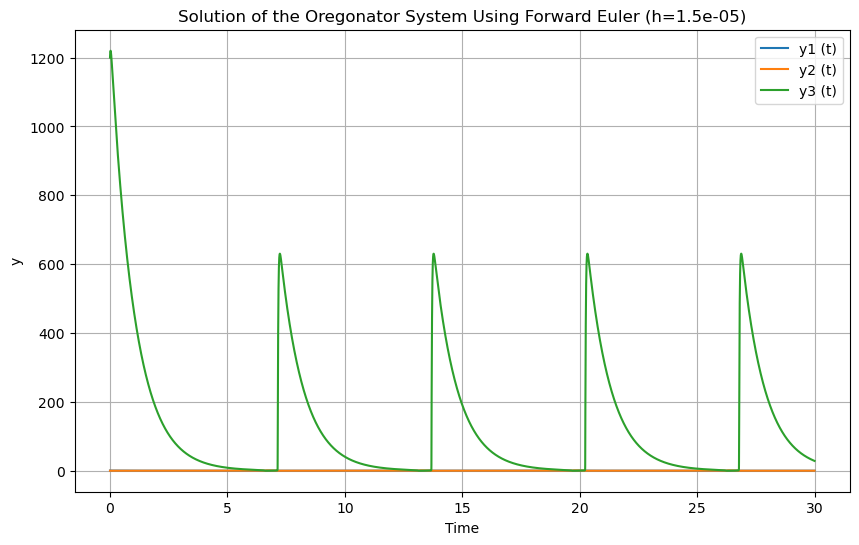

In [27]:
# Initialization
y2_0 = 0.0
y3_0 = 1200.0
initial_conditions = [y1_0, y2_0, y3_0]

# Time
t_scale = (0, 30)
t_end = t_scale[-1]

h_values = np.array([1.7e-03,1.7e-04,1.7e-05, 1.5e-05])

for i,h in enumerate(h_values):
    try:
        t_values, y_values = solve_IVP(oregonator, initial_conditions, h, t_end, method=forward_euler)


        plt.figure(figsize=(10, 6))
        plt.plot(t_values, y_values[:, 0], label="y1 (t)")
        plt.plot(t_values, y_values[:, 1], label="y2 (t)")
        plt.plot(t_values, y_values[:, 2], label="y3 (t)")
        plt.xlabel("Time")
        plt.ylabel("y")
        plt.title(f"Solution of the Oregonator System Using Forward Euler (h={h})")
        plt.legend()
        plt.grid()
        plt.show()

    except (RuntimeWarning, ValueError, OverflowError, np.linalg.LinAlgError) as e:
        print(f"Warning: Encountered instability for h = {h}: {e} Moving to next h {h_values[i+1]}")
        continue

### From the above analysis, we can conclude that the stability constraint for explicit methods, such as the Forward Euler method, imposes the necessity of a very small $h$ for stiff systems. Larger $h$ values result in instability, leads to overflow, divergence, or erratic behavior in $y_1$, $y_2$, and $y_3$. Only when $h$ is sufficiently small do the dynamics stabilize, yielding the expected behavior of the system.


## **Drawback of explicit methods for Stiff System's**

#### **Explicit methods have issues when solving problems with both fast and slow dynamics because:**

 Explicit methods are conditionally stable, meaning they need a small enough time step (Δt) to avoid instability. This stability condition is usually governed by the Courant-Friedrichs-Lewy (CFL) condition. In stiff systems, the fast dynamics require a very small time step to keep the solution stable. This forces the method to use small time steps, which can make them slow, inefficient, and computationally expensive, especially since the slow dynamics don’t need such small time steps. If the time step is too large, the solution can become unstable and inaccurate. Even though small time steps reduce the discretization error (the error made by approximating continuous dynamics with discrete steps), they can cause round-off errors. This happens because computers use finite precision to represent numbers, and these small errors can add up over time, making the final solution inaccurate.

# Task 3

- Question: For Radau5, what are the used time steps as a function of the tolerance ? Compare with the time steps
from the explicit methods. Why is the method optimal for this problem in terms of stability and accuracy
compared to the case of the Brusselator system ?

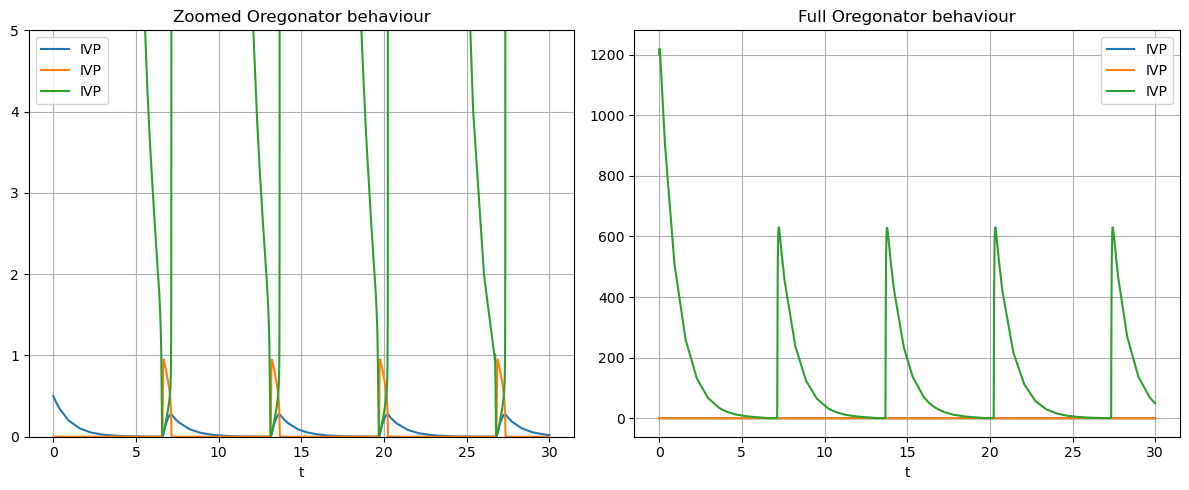

In [36]:
m = lambda t,y : oregonator(t,y)

def radau_gen(f,y,t,rtol = 0.001 ,atol = 1e-6):
    rad_obj = scp.integrate.Radau(f,0,y,t,rtol=rtol, atol=atol)
    while True:
        rad_obj.step()
        yield rad_obj.y, rad_obj.t, rad_obj.step_size
        if rad_obj.t == t:
            break
ts = [0]
ys = [[0.5,0,1200]]
steps = []
for y,t,h in radau_gen(m,np.array([0.5,0,1200]),30):
    ts.append(t)
    ys.append(y)
    steps.append(h)

plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.title("Zoomed Oregonator behaviour")
plt.plot(ts,ys, label=f"IVP")
plt.xlabel(f"t")
plt.ylim(0,5)
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.title("Full Oregonator behaviour")
plt.plot(ts,ys, label=f"IVP")
plt.xlabel(f"t")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [37]:
#
# step sizes used by radau5
#

rtol_space = np.logspace(-6,-1,6)
atol_space = np.logspace(-12,-3,10)

for r in rtol_space:
    for a in atol_space:
    
        steps = []
        for y,t,h in radau_gen(m,np.array([0.5,0,1200]),30, rtol=r, atol=a):
            steps.append(h)
        print(f"rtol: {r} , atol: {a}")
        print("Smallest Step size:",min(steps), "\nLargest Step size:", max(steps))
        print("Number of steps taken:", len(steps))
        print("")

rtol: 1e-06 , atol: 1e-12
Smallest Step size: 5.8925506148884764e-08 
Largest Step size: 0.1091658663316597
Number of steps taken: 1568

rtol: 1e-06 , atol: 1e-11
Smallest Step size: 5.892497561002706e-07 
Largest Step size: 0.11715983550418729
Number of steps taken: 1557

rtol: 1e-06 , atol: 1e-10
Smallest Step size: 9.021762363108098e-07 
Largest Step size: 0.11830297455272287
Number of steps taken: 1538

rtol: 1e-06 , atol: 1e-09
Smallest Step size: 1.5702746694011984e-06 
Largest Step size: 0.11762954683300642
Number of steps taken: 1457

rtol: 1e-06 , atol: 1e-08
Smallest Step size: 2.986503224612747e-06 
Largest Step size: 0.12065711450376071
Number of steps taken: 1351

rtol: 1e-06 , atol: 1e-07
Smallest Step size: 6.331769150633261e-06 
Largest Step size: 0.13300344133812203
Number of steps taken: 1263

rtol: 1e-06 , atol: 1e-06
Smallest Step size: 1.2604046015310994e-05 
Largest Step size: 0.12932219035401538
Number of steps taken: 1153

rtol: 1e-06 , atol: 1e-05
Smallest Step